In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report,accuracy_score

In [2]:
import os
import shutil
import random
# Fungsi untuk membuat struktur folder dan membagi data
def split_data(source_dir, base_dir, train_size=0.8, val_size=0.1, test_size=0.1):
    # Membuat folder utama untuk train, val, dan test
    os.makedirs(base_dir, exist_ok=True)
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'val')
    test_dir = os.path.join(base_dir, 'test')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Menentukan kategori (misalnya acne, non-acne)
    categories = os.listdir(source_dir)

    # Untuk setiap kategori, buat folder di train, val, test dan pindahkan gambar
    for category in categories:
        category_dir = os.path.join(source_dir, category)
        files = os.listdir(category_dir)
        random.shuffle(files)

        # Menghitung jumlah data untuk training, validation, dan testing
        total_files = len(files)
        train_count = int(train_size * total_files)
        val_count = int(val_size * total_files)
        test_count = total_files - train_count - val_count  # Sisanya untuk test

        # Buat folder untuk kategori di setiap subset
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(val_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)

        # Pindahkan file ke folder masing-masing
        for i, file in enumerate(files):
            source_file = os.path.join(category_dir, file)

            if i < train_count:
                target_dir = os.path.join(train_dir, category)
            elif i < train_count + val_count:
                target_dir = os.path.join(val_dir, category)
            else:
                target_dir = os.path.join(test_dir, category)

            shutil.copy(source_file, target_dir)

# Tentukan direktori sumber dan tujuan
source_dir = '/content/drive/MyDrive/BEAUSKIN ML/SKIN_TYPES_DATASET'
base_dir = '/content/drive/MyDrive/BEAUSKIN ML/SKIN_TYPES_DETECTION'

# Panggil fungsi untuk membagi dataset
split_data(source_dir, base_dir)


In [ ]:
# Data generator untuk training
datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode="nearest",
                                   validation_split=0.2)

In [10]:
train_dir = '/content/drive/MyDrive/BEAUSKIN ML/SKIN_TYPES_DETECTION/train'
val_dir = '/content/drive/MyDrive/BEAUSKIN ML/SKIN_TYPES_DETECTION/val'
test_dir = '/content/drive/MyDrive/BEAUSKIN ML/SKIN_TYPES_DETECTION/test'

In [11]:
train_generator = datagen.flow_from_directory(train_dir,
                                                  target_size=(128,128),
                                                  color_mode="rgb",
                                                  class_mode="categorical")

valid_generator = datagen.flow_from_directory(val_dir,
                                                    target_size=(128,128),
                                                    color_mode="rgb",
                                                    class_mode="categorical")

test_datagen = ImageDataGenerator(rescale =1./255)
test_generator = datagen.flow_from_directory(test_dir,
                                                   target_size=(128,128),
                                                   color_mode="rgb",
                                                   class_mode="categorical")

Found 1683 images belonging to 3 classes.
Found 209 images belonging to 3 classes.
Found 213 images belonging to 3 classes.


In [12]:
# Mendapatkan label dari train_generator
class_labels = train_generator.class_indices
print("Class Labels:", class_labels)

Class Labels: {'dry': 0, 'normal': 1, 'oily': 2}


In [13]:
# Load MobileNetV2 dengan pretrained weights dari ImageNet, tanpa lapisan top
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

9406464/9406464 [==============================] - 0s 0us/step


In [14]:
base_model.trainable = False

In [15]:
# Memulai dengan input base model
x = base_model.output

# Tambahkan lapisan pooling global
x = GlobalAveragePooling2D()(x)

# Tambahkan lapisan Dense untuk klasifikasi
x = Dense(128, activation='relu')(x)
x = Dense(3, activation='softmax')(x)  # 3 output neurons untuk 3 kelas kulit

# Membuat model akhir
model = Model(inputs=base_model.input, outputs=x)

In [16]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
# class EarlyStoppingCallback(Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         if logs.get('accuracy') >= 0.97 and logs.get('val_accuracy') >= 0.97:
#             print(f"\nAkurasi training sudah mencapai 95% , dan validation accuracy sudah mencapai 95% pada epoch {epoch + 1}. Menghentikan pelatihan.")
#             self.model.stop_training = True

In [24]:
# Training model
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=10,
                    verbose = 1,
                    )

Epoch 1/10
53/53 [==============================] - 17s 326ms/step - loss: 0.0877 - accuracy: 0.9661 - val_loss: 0.1535 - val_accuracy: 0.9522
Epoch 2/10
53/53 [==============================] - 17s 317ms/step - loss: 0.0839 - accuracy: 0.9673 - val_loss: 0.1715 - val_accuracy: 0.9378
Epoch 3/10
53/53 [==============================] - 17s 321ms/step - loss: 0.0725 - accuracy: 0.9739 - val_loss: 0.1314 - val_accuracy: 0.9569
Epoch 4/10
53/53 [==============================] - 17s 317ms/step - loss: 0.0679 - accuracy: 0.9774 - val_loss: 0.1238 - val_accuracy: 0.9713
Epoch 5/10
53/53 [==============================] - 17s 322ms/step - loss: 0.0766 - accuracy: 0.9691 - val_loss: 0.1750 - val_accuracy: 0.9378
Epoch 6/10
53/53 [==============================] - 17s 321ms/step - loss: 0.0608 - accuracy: 0.9780 - val_loss: 0.1268 - val_accuracy: 0.9522
Epoch 7/10
53/53 [==============================] - 17s 318ms/step - loss: 0.0607 - accuracy: 0.9762 - val_loss: 0.1792 - val_accuracy: 0.9569

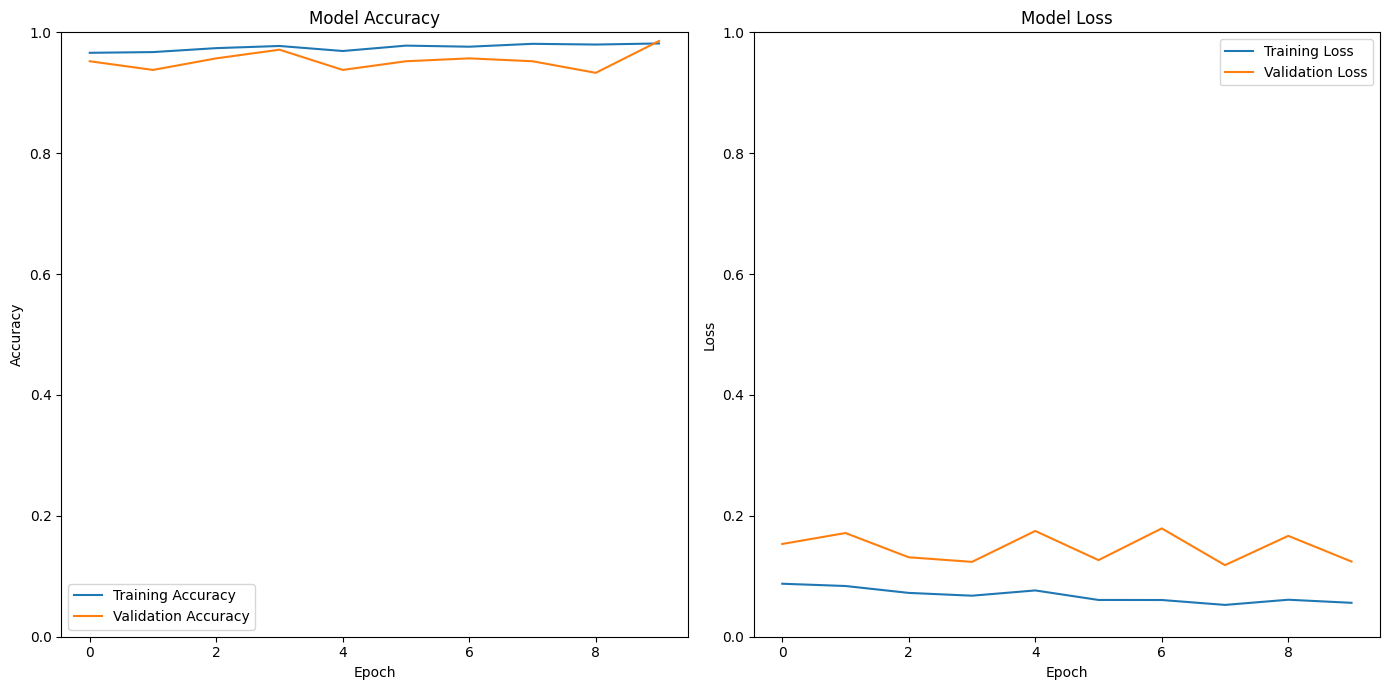

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Plot training & validation accuracy values
plt.figure(figsize=(14, 7))  # Increase figure size for better clarity

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.ylim([0, 1])

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.ylim([0, 1])

plt.tight_layout()
plt.show()


In [26]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

6/6 [==============================] - 2s 272ms/step - loss: 0.1675 - accuracy: 0.9323
Test Loss: 0.16746950149536133
Test Accuracy: 0.9322916865348816


In [38]:
model.save('skintypes_detection_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


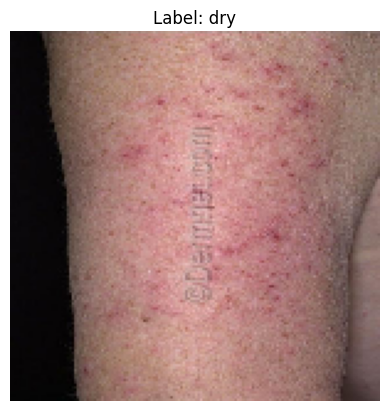

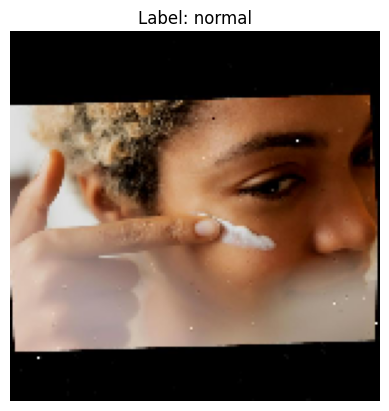

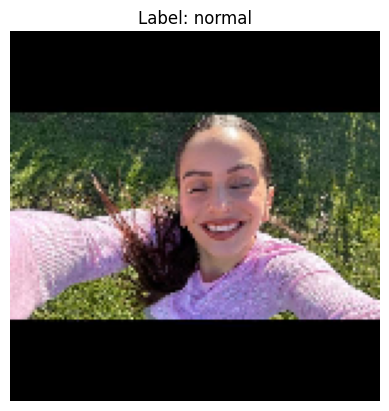

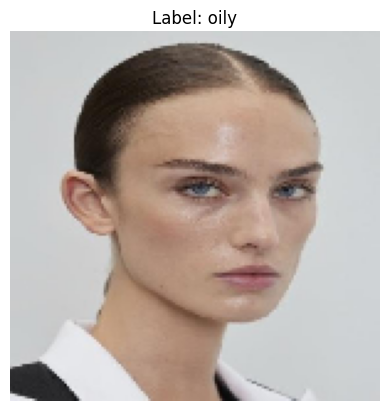

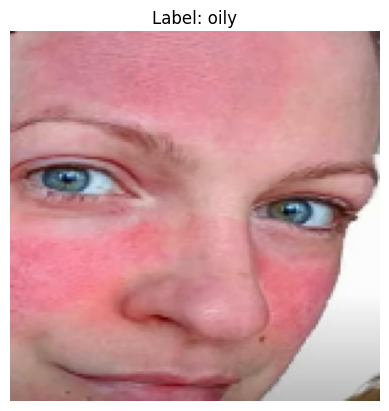

In [33]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image


# Get the list of categories (subfolders)
categories = os.listdir(test_dir)

# Function to load and display a random image with its label
def load_and_display_random_image_with_label():
    # Randomly select a category (label)
    category = random.choice(categories)

    # Get the list of image files in the selected category
    category_path = os.path.join(test_dir, category)
    files = os.listdir(category_path)

    # Randomly select a file
    selected_file = random.choice(files)
    selected_image_path = os.path.join(category_path, selected_file)

    # Load and preprocess the image
    img = image.load_img(selected_image_path, target_size=(150, 150))

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title(f"Label: {category}")  # Display the label as title
    plt.show()

# Display two random images with their labels
for _ in range(5):
    load_and_display_random_image_with_label()


In [39]:
from google.colab import files

# Buat converter TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Konversi model ke format TensorFlow Lite
tflite_model = converter.convert()

# Simpan model TensorFlow Lite ke file
tflite_model_path = 'skintypes_detection_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print("Model berhasil dikonversi ke TensorFlow Lite dan disimpan sebagai model.tflite")

# Unduh file model .tflite
files.download(tflite_model_path)

Model berhasil dikonversi ke TensorFlow Lite dan disimpan sebagai model.tflite


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>